In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.stats import f
from calendar import day_abbr
import locale
import os
from my_functions import DST_trafo
import seaborn as sns
import statsmodels.api as sm
#import glmnet
from sklearn.preprocessing import StandardScaler
#from glmnet import ElasticNet
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
from forecast_functions import *
from scipy.stats import skew, kurtosis
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from bspline import Bspline
from scipy.stats import ttest_rel

In [2]:
data= pd.read_csv("FR_price.csv") #final dataset after remove unrelavant predictors and drop outlier

In [3]:
data

DateTime  FR_Price_DA  FR_Load_DA  FR_Nuclear_Output  \
0      2015-01-04T23:00:00Z        36.56       62.90             56.499   
1      2015-01-05T00:00:00Z        34.94       60.25             57.024   
2      2015-01-05T01:00:00Z        32.19       59.65             57.350   
3      2015-01-05T02:00:00Z        23.53       56.50             55.512   
4      2015-01-05T03:00:00Z        22.92       55.05             54.950   
...                     ...          ...         ...                ...   
76626  2023-10-02T17:00:00Z       182.02       49.15             37.705   
76627  2023-10-02T18:00:00Z       160.07       49.30             36.763   
76628  2023-10-02T19:00:00Z       120.00       45.65             36.477   
76629  2023-10-02T20:00:00Z       103.25       43.85             36.675   
76630  2023-10-02T21:00:00Z       100.00       45.50             36.923   

       FR_HydroWater_Output  FR_Gas_Output  FR_Oil_Output  FR_Residual_Load  \
0                     0.819          2.435          0.261          61.48123   
1                     0.714          2.451          0.261          58.84145   
2                     0.624          2.456          0.262          58.36858   
3                     0.515          2.481          0.261          55.34581   
4                     0.481          2.654          0.261          54.02193   
...                     ...            ...            ...               ...   
76626                 2.252          3.571          0.143          43.64310   
76627                 2.614          3.542          0.143          43.37417   
76628                 2.183          3.107          0.143          38.74269   
76629                 1.663          3.153          0.143          35.96108   
76630                 1.003          2.713          0.143          36.62941   

       DE_Price_DA  DE_Load_DA  ...  IT_Load_DA  BE_Load_DA  Coal_fM  Coal_fQ  \
0            22.34    43.17617  ...      11.161     9.74709    53.43    52.58   
1            17.93    41.59758  ...      10.375     9.56003    52.74    51.69   
2            15.17    40.42159  ...      10.085     9.08613    52.74    51.69   
3            16.38    40.40436  ...       9.946     8.78327    52.74    51.69   
4            17.38    41.34813  ...      10.034     8.65436    52.74    51.69   
...            ...         ...  ...         ...         ...      ...      ...   
76626       245.05    55.17198  ...      21.410     9.94580      NaN      NaN   
76627       160.07    53.21370  ...      20.445     9.69598      NaN      NaN   
76628       120.00    49.83315  ...      19.065     9.31059      NaN      NaN   
76629       107.03    45.10129  ...      17.258     8.85516      NaN      NaN   
76630       100.00    42.07174  ...      16.028     8.41301      NaN      NaN   

       Coal_fY  Gas_fD  Gas_fM  Gas_fQ  Gas_fY  Oil_fM  
0        51.97    19.8   20.14   19.68   20.40   44.51  
1        51.30    19.2   19.54   19.09   20.03   42.98  
2        51.30    19.2   19.54   19.09   20.03   42.98  
3        51.30    19.2   19.54   19.09   20.03   42.98  
4        51.30    19.2   19.54   19.09   20.03   42.98  
...        ...     ...     ...     ...     ...     ...  
76626      NaN     NaN     NaN     NaN     NaN     NaN  
76627      NaN     NaN     NaN     NaN     NaN     NaN  
76628      NaN     NaN     NaN     NaN     NaN     NaN  
76629      NaN     NaN     NaN     NaN     NaN     NaN  
76630      NaN     NaN     NaN     NaN     NaN     NaN  

[76631 rows x 24 columns]

## Lasso and Ridge Regression

In [5]:

# Setup local time, language
locale.setlocale(locale.LC_ALL, 'EN_US')
locale.getlocale()
data["DateTime"]= pd.to_datetime(data["DateTime"],
                           utc=True, format="%Y-%m-%dT%H:%M:%SZ")
# Extract price data
price = data.loc[:, "FR_Price_DA"]
time_utc = pd.to_datetime(data["DateTime"],
                          utc=True, format="%Y-%m-%d %H:%M:%S")
local_time_zone = "CET"
time_lt = time_utc.dt.tz_convert(local_time_zone)

S = 24
# %% Save the start and end-time
start_end_time_S = time_lt.iloc[[0, -1]
                                ].dt.tz_localize(None).dt.tz_localize("UTC")
# %% creating 'fake' local time
start_end_time_S_num = pd.to_numeric(start_end_time_S)
time_S_numeric = np.arange(
    start=start_end_time_S_num.iloc[0],
    stop=start_end_time_S_num.iloc[1] + 24 * 60 * 60 * 10 ** 9 / S,
    step=24 * 60 * 60 * 10 ** 9 / S,
)
# %% 'fake' local time
time_S = pd.Series(pd.to_datetime(time_S_numeric, utc=True))
dates_S = pd.Series(time_S.dt.date.unique())
# %% import DST_trafo function and use it on data
data_array = DST_trafo(X=data.iloc[:, 1:], Xtime=time_utc, tz=local_time_zone)
data_array.shape
# %% save as dataframe
price_S = pd.DataFrame(data_array[..., 0], index=dates_S)
reg_names = data.columns[1:]
data.iloc[:, 1:].head()

FR_Price_DA  FR_Load_DA  FR_Nuclear_Output  FR_HydroWater_Output  \
0        36.56       62.90             56.499                 0.819   
1        34.94       60.25             57.024                 0.714   
2        32.19       59.65             57.350                 0.624   
3        23.53       56.50             55.512                 0.515   
4        22.92       55.05             54.950                 0.481   

   FR_Gas_Output  FR_Oil_Output  FR_Residual_Load  DE_Price_DA  DE_Load_DA  \
0          2.435          0.261          61.48123        22.34    43.17617   
1          2.451          0.261          58.84145        17.93    41.59758   
2          2.456          0.262          58.36858        15.17    40.42159   
3          2.481          0.261          55.34581        16.38    40.40436   
4          2.654          0.261          54.02193        17.38    41.34813   

   CH_Price_DA  ...  IT_Load_DA  BE_Load_DA  Coal_fM  Coal_fQ  Coal_fY  \
0        37.80  ...      11.161     9.74709    53.43    52.58    51.97   
1        34.09  ...      10.375     9.56003    52.74    51.69    51.30   
2        31.89  ...      10.085     9.08613    52.74    51.69    51.30   
3        28.50  ...       9.946     8.78327    52.74    51.69    51.30   
4        27.23  ...      10.034     8.65436    52.74    51.69    51.30   

   Gas_fD  Gas_fM  Gas_fQ  Gas_fY  Oil_fM  
0    19.8   20.14   19.68   20.40   44.51  
1    19.2   19.54   19.09   20.03   42.98  
2    19.2   19.54   19.09   20.03   42.98  
3    19.2   19.54   19.09   20.03   42.98  
4    19.2   19.54   19.09   20.03   42.98  

[5 rows x 23 columns]

In [6]:
# Extract price data
price = data.loc[:, "FR_Price_DA"]

# Create Plotly figure
fig = go.Figure()

# Add line trace
fig.add_trace(go.Scatter(x=time_utc, y=data.iloc[:, 1], mode='lines', name='Price'))

# Update layout
fig.update_layout(
    title='Price Over Time',
    xaxis_title='Time',
    yaxis_title='Price in EUR/MWh',
    template='plotly',  # Use a dark theme, you can choose another template if you prefer
    showlegend=True
)

# Show the interactive plot
fig.show()

In [7]:
N_test = 365 # testing size 1*365*24
D = 365 * 5  # 5 years training
N = price_S.shape[0] - D - N_test  # validation window
N_test = price_S.shape[0] - D - N  # testing window

training_set = price_S.iloc[:D]
validation_set = price_S.iloc[D:D + N]
testing_set = price_S.iloc[D + N:]
oos_dates = dates_S[D:N+D]
oos_dates_test = dates_S[D + N:]
model_names = ["true", "naive", "expert", "expert.readv", "expert.last", "lasso", "ridge", "elastic"]
number_of_models = len(model_names)
expert_wd = [1, 6, 7]
expert_lags = [1, 2, 7]

fuel_lags=[2]
output_lags=[1]
lambdas = 2**(np.linspace(0.5, -5, 50))
# create the empty array (3D in here) to store the forecast. 
forecasts = np.full((N, S, number_of_models), np.nan)
dim_names = [oos_dates.values, np.arange(S), model_names]

forecasts_test = np.full((N_test, S, number_of_models), np.nan)
dim_names = [oos_dates.values, np.arange(S), model_names]

### Naive model

In [8]:
def forecast_naive(Y, days):
    weekday = (days.iloc[-1] + pd.DateOffset(1)
               ).weekday() + 1  # 1 - Mon, ... , 7 - Sun
    if weekday in [1, 6, 7]:  # if Mon, Sat, Sun, use the previous week
        forecast = Y.values[-7]
    else: 
        forecast = Y.values[-1]
    return {"forecasts": forecast, "coefficients": None}

for n in range(N):
    Y = price_S.iloc[n:D+n]
    days = pd.to_datetime(dates_S[n:D+n], utc=True)

    fc_naive = forecast_naive(Y=Y, days=days) #naive
    forecasts[n, :, 1] = fc_naive["forecasts"]


    print("\r-> "+str(np.round((n+1)/N*100, 4))+"% done", end='')

-> 100.0% donene

## Expert model

In [9]:
def forecast_expert(Y, days, expert_wd=[1, 6, 7], expert_lags=[1, 2, 7]):
    S = Y.shape[1]
    forecast = np.repeat(np.nan, S)

    days_ext = pd.concat((days, pd.Series(days.iloc[-1] + pd.DateOffset(1),
                                          index=[len(days)])))
    # preparation of weekday dummies including the day to forecast
    weekdays_num = days_ext.dt.weekday+1  # 1 = Mon, 2 = Tue, ..., 7 = Sun
    WD = np.transpose([(weekdays_num == x) + 0 for x in expert_wd])
    WD = WD[7:, ]

    # preparation of lags :
    def get_lagged(lag, Z):
        return np.concatenate((np.repeat(np.nan, lag), Z[:(len(Z) + 1-lag)]))

    coefs = np.empty((S, len(expert_wd)+len(expert_lags)+1))

    for s in range(S):
        # prepare the Y vector
        YREG = Y.iloc[:, s].values

        # get lags
        XLAG = np.transpose([get_lagged(lag=lag, Z=YREG)
                            for lag in expert_lags])

        # combine to X matrix
        XREG = np.column_stack((np.ones(Y.shape[0]+1), WD, XLAG))

        act_index = ~ np.isnan(XREG).any(axis=1)
        act_index[-1] = False  # no NAs and no last obs
        model = LinearRegression(fit_intercept=False).fit(
            X=XREG[act_index], y=YREG[act_index[:-1]])

        forecast[s] = model.coef_ @ XREG[-1]
        coefs[s] = model.coef_

    regressor_names = ["intercept"]+[
        day_abbr[i-1]
        for i in expert_wd]+["lag "+str(lag)
                             for lag in expert_lags]

    coefs_df = pd.DataFrame(coefs, columns=regressor_names)

    return {"forecasts": forecast, "coefficients": coefs_df}

In [ ]:
for n in range(N):

    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])
    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    fc_expert = forecast_expert(Y=Y, days=days, expert_wd=expert_wd,
                                expert_lags=expert_lags)
    forecasts[n, :, 2] = fc_expert["forecasts"]

    print("\r-> "+str(np.round((n+1)/N*100, 4))+"% done", end='')


In [ ]:
final_best_coefs = fc_expert["coefficients"]
print("\nFinal Best Coefficients:")
print(final_best_coefs)


Final Best Coefficients:
    intercept        Mon        Sat        Sun     lag 1     lag 2     lag 3  \
0    4.538789  -7.347137  -3.310781 -12.174195  0.676271  0.153868 -0.007504   
1    4.653222  -6.559806  -3.358170 -12.976388  0.688340  0.138684 -0.071254   
2    4.629978  -5.075192  -3.633478 -14.057860  0.660197  0.156403 -0.064526   
3    4.478435  -4.021232  -2.809532 -14.276395  0.672794  0.116827 -0.059944   
4    4.594675  -2.216873  -4.544488 -14.990282  0.695507  0.067512 -0.019902   
5    4.248260   5.579532  -8.157307 -17.470043  0.674519  0.069895  0.021137   
6    3.089628  19.966622 -12.878656 -19.131938  0.751054 -0.103631  0.091694   
7    3.788463  27.052822 -19.361681 -23.240823  0.645410 -0.036498  0.064406   
8    3.672611  29.925492 -19.501182 -24.259621  0.653412 -0.017202  0.000303   
9    3.633496  24.958353 -16.845591 -23.013515  0.655616 -0.012099  0.015464   
10   3.773542  22.272214 -16.550788 -21.199907  0.644934 -0.000725  0.022183   
11   3.680063 

## Expert.last model

In [ ]:
def forecast_expert_last(Y, days, expert_wd=[1, 6, 7], expert_lags=[1, 2, 7]):
    S = Y.shape[1]
    forecast = np.repeat(np.nan, S)

    days_ext = pd.concat((days, pd.Series(days.iloc[-1] + pd.DateOffset(1),
                                          index=[len(days)])))

    weekdays_num = days_ext.dt.weekday+1  # 1 = Mon, 2 = Tue, ..., 7 = Sun
    WD = np.transpose([(weekdays_num == x) + 0 for x in expert_wd])
    WD = WD[7:, ]
    
    # preparation of lags :
    def get_lagged(lag, Z):
        return np.concatenate((np.repeat(np.nan, lag), Z[:(len(Z) + 1-lag)]))

    # expert specification
    xlag_last_hour = get_lagged(lag=1, Z=Y.values[:, S-1])
    coefs = np.empty((S, len(expert_wd)+len(expert_lags)+2))

    for s in range(S):
        # prepare the Y vector
        YREG = Y.iloc[:, s].values

        # get lags
        XLAG = np.transpose([get_lagged(lag=lag, Z=YREG)
                            for lag in expert_lags])

        # combine to X matrix
        XREG = np.column_stack(
            (np.ones(Y.shape[0]+1), WD, XLAG, xlag_last_hour))

        act_index = ~ np.isnan(XREG).any(axis=1)
        act_index[-1] = False  # no NAs and no last obs
        model = LinearRegression(fit_intercept=False).fit(
            X=XREG[act_index], y=YREG[act_index[:-1]])

        forecast[s] = model.coef_ @ XREG[-1]
        coefs[s] = model.coef_

    regressor_names = ["intercept"]+[
        day_abbr[i-1]
        for i in expert_wd]+["lag "+str(lag)
                             for lag in expert_lags]+["lag 1 s="+str(S-1)]

    coefs_df = pd.DataFrame(coefs, columns=regressor_names)

    return {"forecasts": forecast, "coefficients": coefs_df}


In [ ]:
for n in range(N):

    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])
    #Y = price_S.iloc[n:D + n]
    days = pd.to_datetime(dates_S[n:D + n], utc=True)
    
    fc_expert_last = forecast_expert_last(Y=Y, days=days, expert_wd=expert_wd,
                                expert_lags=expert_lags)

    print("\r-> "+str(np.round((n+1)/N*100, 4))+"% done", end='')

-> 100.0% donene

## Expert.readv model

wrong

In [ ]:
def forecast_expert_ext(Y, days, expert_wd, expert_lags, fuel_lags, output_lags, index):
    S = Y.shape[1]
    forecast = np.repeat(np.nan, S)

    days_ext = pd.concat((days, pd.Series(days.iloc[-1] + pd.DateOffset(1),
                                          index=[len(days)])))
    weekdays_num = days_ext.dt.weekday+1  # 1 = Mon, 2 = Tue, ..., 7 = Sun
    WD = np.transpose([(weekdays_num == x) + 0 for x in expert_wd])
    WD = WD[8:, ]

     # preparation of lags:
    def get_lagged(Z, lag):
        return np.concatenate((np.repeat(np.nan, lag), Z[:(len(Z)-lag)]))   
    
    xprice_temp = np.column_stack([
        data_array[index, S-1, reg_names == "FR_Price_DA"],#last hour (S-1)
        data_array[index, :, reg_names == "FR_Price_DA"].min(1), #min value of hour s
        data_array[index, :, reg_names == "FR_Price_DA"].max(1) #max value of hour s
        ])
    xprice = np.apply_along_axis(get_lagged, 0, xprice_temp, lag=1)

    fuel_names = ["Coal_fM", "Coal_fQ", "Coal_fY", "Gas_fD", "Gas_fM", "Gas_fQ", "Gas_fY", "Oil_fM"]

    xfuels = np.concatenate([np.apply_along_axis(
        get_lagged, 0, data_array[index][:, 0, reg_names.isin(fuel_names)], lag=l)
        for l in fuel_lags], axis=-1)
    

    da_forecast_names = ['FR_Load_DA', 'FR_Residual_Load'] 
    regressor_names = ["intercept"] + ["lag "+str(lag) for lag in expert_lags] + \
                    ["last", "min", "max"] + [day_abbr[i-1] for i in expert_wd] + \
                    da_forecast_names + fuel_names #+ output_names 

    coefs = np.empty((S, len(regressor_names)))

    for s in range(S):

        ext = data_array[index][:, s, reg_names.isin(da_forecast_names)]
    
        YREG = Y.iloc[:, s].values

        XLAG = np.column_stack([get_lagged(lag=lag, Z=YREG) for lag in expert_lags]) 
        intercept= np.ones((XLAG.shape[0], 1))
        XREG = np.column_stack([intercept, XLAG, xprice, WD, ext, xfuels]) 
      

        act_index = ~np.isnan(XREG).any(axis=1)
        act_index[-1] = False

        model = LinearRegression(fit_intercept=False).fit(X=XREG[act_index[:]], y=YREG[act_index[:]])

   
        model.coef_[np.isnan(model.coef_)] = 0

        forecast[s] = model.coef_@ XREG[-1]
        coefs[s] = model.coef_

    coefs_df = pd.DataFrame(coefs, columns=regressor_names)

    return {"forecasts": forecast, "coefficients": coefs_df}

In [ ]:
for n in range(N):
    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])
    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    fc_expert_readv= forecast_expert_ext(Y=Y, days=days, expert_wd=expert_wd, expert_lags=expert_lags, 
                              fuel_lags=fuel_lags, output_lags=output_lags, index=index)
    forecasts[n, :, 4] = fc_expert_readv["forecasts"]

    print("\r-> "+str(np.round((n+1)/N*100, 4))+"% done", end='')



-> 100.0% donene

### Function for LASSO

In [ ]:

def forecast_lasso(Y, days, expert_wd, expert_lags, lambdas, fuel_lags, output_lags, index):
    index_ext = np.append(index, index[-1] +1)
    
    S = Y.shape[1]
    forecast = np.repeat(np.nan, S)

    days_ext = pd.concat((days, pd.Series(days.iloc[-1] + pd.DateOffset(1), index=[len(days)])))
    weekdays_num = days_ext.dt.weekday + 1
    WD = np.transpose([(weekdays_num == x) + 0 for x in expert_wd])
    WD = WD[7:,]

    def get_lagged(Z, lag):
        return np.concatenate((np.repeat(np.nan, lag), Z[:(len(Z) + 1 - lag)]))
    
    xprice_temp = np.column_stack([
        data_array[index, S-1, reg_names == "FR_Price_DA"],#last hour (S-1)
        data_array[index, :, reg_names == "FR_Price_DA"].min(1), #min value of hour s
        data_array[index, :, reg_names == "FR_Price_DA"].max(1) #max value of hour s
        ])
    xprice = np.apply_along_axis(get_lagged, 0, xprice_temp, lag=1)

    fuel_names = ["Coal_fM", "Coal_fQ", "Coal_fY", "Gas_fD", "Gas_fM", "Gas_fQ", "Gas_fY", "Oil_fM"]

    xfuels = np.concatenate([np.apply_along_axis(
        get_lagged, 0, data_array[index][:, 0, reg_names.isin(fuel_names)], lag=l)
        for l in fuel_lags], axis=-1)
    
    # %% externals
    output_names = ['FR_Nuclear_Output','FR_HydroWater_Output','FR_Gas_Output','FR_Oil_Output']
    
    xoutputs = np.concatenate([np.apply_along_axis(
        get_lagged, 0, data_array[index][:, 0, reg_names.isin(output_names)], lag=l)
        for l in output_lags], axis=-1)
    # Initialize regressor_names here
    da_forecast_names = ['FR_Load_DA', 'FR_Residual_Load', 'CH_Price_DA', 'CH_Load_DA', 
                             'IT_Price_DA', 'IT_Load_DA', 'BE_Load_DA', 'ES_Price_DA', 'DE_Price_DA', 'DE_Load_DA']
    regressor_names = ["lag "+str(lag) for lag in expert_lags] + \
                    ["last", "min", "max"] + [day_abbr[i-1] for i in expert_wd] + \
                    da_forecast_names + fuel_names + output_names
    coefs = np.empty((S, len(regressor_names)))

    best_alpha = np.full(S, np.nan)
    best_coefs = np.full((S, len(regressor_names)), np.nan)

    for s in range(S):
        
        ext = data_array[index_ext][:, s, reg_names.isin(da_forecast_names)]

        YREG = Y.iloc[:, s].values

        XLAG = np.column_stack([get_lagged(lag=lag, Z=YREG) for lag in expert_lags]) #price lag
        
        XREG = np.column_stack([XLAG, xprice, WD, ext, xfuels, xoutputs])
    

        act_index = ~np.isnan(XREG).any(axis=1)
        act_index[-1] = False

        XREG_mean = np.mean(XREG[act_index], axis=0)
        XREG_std = np.std(XREG[act_index], axis=0)
        XREG_scaled = (XREG[act_index] - XREG_mean) / XREG_std
        XREG_scaled[:, 0] = 1

        YREG_mean = np.mean(YREG[act_index[:-1]], axis=0)
        YREG_std = np.std(YREG[act_index[:-1]], axis=0)
        YREG_scaled = (YREG[act_index[:-1]] - YREG_mean) / YREG_std

        model_lasso_scaled = LassoCV(alphas=lambdas, cv=5).fit(X=XREG_scaled, y=YREG_scaled)

        best_alpha[s] = model_lasso_scaled.alpha_
        best_coefs[s, :] = model_lasso_scaled.coef_

        forecast[s] = best_coefs[s, :] @ XREG[-1]
        coefs[s] = best_coefs[s, :]

    coefs_df = pd.DataFrame(coefs, columns=regressor_names)

    return {"forecasts": forecast, "coefficients": coefs_df, "best_alpha": best_alpha, "best_coefs": best_coefs}


In [ ]:
# Loop for forecasting
for n in range(N):
    ## true price for comparing
    forecasts[n, :, 0] = price_S.iloc[D + n]

    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])

    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    # Lasso model
    fc_lasso = forecast_lasso(Y=Y, days=days, expert_wd=expert_wd, expert_lags=expert_lags, lambdas=lambdas, 
                              fuel_lags=fuel_lags, output_lags=output_lags, index=index) # , index_ext=index_ext
    forecasts[n, :, 5] = fc_lasso["forecasts"]


# Access the dataframes
final_forecast_lasso = forecasts[-1, :, 5]
final_best_alpha_lasso = fc_lasso["best_alpha"][-1]
final_best_coefs_df_lasso = fc_lasso["best_coefs"][-1]

# Print the dataframes
print("Final Forecast:")
print(final_forecast_lasso)
print("\nFinal Best Alpha:")
print(final_best_alpha_lasso)
print("\nFinal Best Coefficients:")
print(final_best_coefs_df_lasso)

Final Forecast:
[180.73943412 160.88830322 137.96899241 125.6733217  121.646334
 130.36048011 165.47764439 212.24377955 150.35068553 115.71530655
 159.20879872 128.70870983 131.09475441  93.13206441  61.10691874
  75.51151774 137.28341524 238.28623206 262.26656439 329.64841249
 336.08030799 277.45095924 278.51043484 270.13905053]

Final Best Alpha:
0.0009765625

Final Best Coefficients:
[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00 -2.60297138e-03
 -0.00000000e+00  0.00000000e+00  1.86292793e-02  4.90262293e-02
  0.00000000e+00  5.39963093e-02 -2.10281204e-03 -5.34041348e-04
  0.00000000e+00 -5.62297182e-02  8.69343975e-02  8.90890278e-02
 -7.41817604e-03  5.64224747e-01 -8.06738961e-03  5.78144161e-03
  4.93370227e-01 -3.56180331e-03 -0.00000000e+00 -5.44125887e-04
 -0.00000000e+00  0.00000000e+00 -4.36525071e-02 -1.93040089e-01
 -0.00000000e+00 -3.82201338e-02 -2.94559210e-03 -1.60197823e-02
  2.53279451e-03 -2.35792899e-03  1.51807574e-03]


### Function for Ridge

In [ ]:
lambdas = 2**(np.linspace(0.5, -3, 10))

def forecast_ridge(Y, days, expert_wd, expert_lags, lambdas, fuel_lags, output_lags, index):
    index_ext = np.append(index, index[-1] + 1)

    S = Y.shape[1]
    forecast = np.repeat(np.nan, S)

    days_ext = pd.concat((days, pd.Series(days.iloc[-1] + pd.DateOffset(1), index=[len(days)])))
    weekdays_num = days_ext.dt.weekday + 1
    WD = np.transpose([(weekdays_num == x) + 0 for x in expert_wd])
    WD = WD[7:, ]

    def get_lagged(Z, lag):
        return np.concatenate((np.repeat(np.nan, lag), Z[:(len(Z) + 1 - lag)]))

    xprice_temp = np.column_stack([
        data_array[index, S-1, reg_names == "FR_Price_DA"],  # last hour (S-1)
        data_array[index, :, reg_names == "FR_Price_DA"].min(1),  # min value of hour s
        data_array[index, :, reg_names == "FR_Price_DA"].max(1)  # max value of hour s
    ])
    xprice = np.apply_along_axis(get_lagged, 0, xprice_temp, lag=1)

    fuel_names = ["Coal_fM", "Coal_fQ", "Coal_fY", "Gas_fD", "Gas_fM", "Gas_fQ", "Gas_fY", "Oil_fM"]

    xfuels = np.concatenate([np.apply_along_axis(
        get_lagged, 0, data_array[index][:, 0, reg_names.isin(fuel_names)], lag=l)
        for l in fuel_lags], axis=-1)

    # %% externals
    output_names = ['FR_Nuclear_Output', 'FR_HydroWater_Output', 'FR_Gas_Output', 'FR_Oil_Output']

    xoutputs = np.concatenate([np.apply_along_axis(
        get_lagged, 0, data_array[index][:, 0, reg_names.isin(output_names)], lag=l)
        for l in output_lags], axis=-1)

    da_forecast_names = ['FR_Load_DA', 'FR_Residual_Load', 'CH_Price_DA', 'CH_Load_DA',
                         'IT_Price_DA', 'IT_Load_DA', 'BE_Load_DA', 'ES_Price_DA', 'DE_Price_DA',
                         'DE_Load_DA'] 
    regressor_names = ["lag " + str(lag) for lag in expert_lags] + \
                      ["last", "min", "max"] + [day_abbr[i - 1] for i in expert_wd] + \
                      da_forecast_names + fuel_names + output_names
    coefs = np.empty((S, len(regressor_names)))

    best_alpha = np.full(S, np.nan)
    best_coefs = np.full((S, len(regressor_names)), np.nan)

    for s in range(S):

        ext = data_array[index_ext][:, s, reg_names.isin(da_forecast_names)]

        YREG = Y.iloc[:, s].values

        XLAG = np.column_stack([get_lagged(lag=lag, Z=YREG) for lag in expert_lags])  # price lag

        XREG = np.column_stack([XLAG, xprice, WD, ext, xfuels, xoutputs])

        act_index = ~np.isnan(XREG).any(axis=1)
        act_index[-1] = False

        XREG_mean = np.mean(XREG[act_index], axis=0)
        XREG_std = np.std(XREG[act_index], axis=0)
        XREG_scaled = (XREG[act_index] - XREG_mean) / XREG_std
        XREG_scaled[:, 0] = 1

        YREG_mean = np.mean(YREG[act_index[:-1]], axis=0)
        YREG_std = np.std(YREG[act_index[:-1]], axis=0)
        YREG_scaled = (YREG[act_index[:-1]] - YREG_mean) / YREG_std

        model_ridge_scaled = RidgeCV(alphas=lambdas, cv=5).fit(X=XREG_scaled, y=YREG_scaled)

        best_alpha[s] = model_ridge_scaled.alpha_
        best_coefs[s, :] = model_ridge_scaled.coef_

        forecast[s] = best_coefs[s, :] @ XREG[-1]
        coefs[s] = best_coefs[s, :]

    coefs_df = pd.DataFrame(coefs, columns=regressor_names)

    return {"forecasts": forecast, "coefficients": coefs_df, "best_alpha": best_alpha, "best_coefs": best_coefs}


In [ ]:
# Loop for forecasting
for n in range(N):

    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])

    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    # Ridge model
    fc_ridge = forecast_ridge(Y=Y, days=days, expert_wd=expert_wd, expert_lags=expert_lags, lambdas=lambdas, 
                              fuel_lags=fuel_lags, output_lags=output_lags, index=index) 
    forecasts[n, :, 6] = fc_ridge["forecasts"]

final_forecast_ridge = forecasts[-1, :, 6]
final_best_alpha_ridge = fc_ridge["best_alpha"][-1]
final_best_coefs_df_ridge = fc_ridge["best_coefs"][-1]


# Print the dataframes
print("Final Forecast:")
print(final_forecast_ridge)
print("\nFinal Best Alpha:")
print(final_best_alpha_ridge)
print("\nFinal Best Coefficients:")
print(final_best_coefs_df_ridge)

Final Forecast:
[178.61575064 151.94645432 130.34419321 114.11007144 105.3017183
 117.64547888 156.09010224 211.11135977 144.87085261 108.32956712
 161.481056   124.2117204  131.28872833  86.48430904  52.15616181
  72.10152971 137.23431092 241.39976187 265.99594281 330.09777482
 340.03103987 282.59836725 291.40112257 270.64369661]

Final Best Alpha:
1.4142135623730951

Final Best Coefficients:
[ 0.          0.01502778 -0.00550058 -0.02095026 -0.02750944  0.0216696
  0.04445418  0.06527213 -0.01451235  0.06386588 -0.00244358  0.00125166
  0.00228154 -0.08668742  0.10878401  0.09256103 -0.00291759  0.58382637
 -0.00722091  0.02165531  0.51845092 -0.00980296  0.00363855 -0.10336919
  0.04318552  0.06056018 -0.09027951 -0.24125786  0.04014979 -0.06325906
 -0.00703025 -0.01289763  0.00471679 -0.00475949  0.00325546]


### Function for Elastic

In [ ]:

lambdas = 2**(np.linspace(0.5, -5, 10))

def forecast_sg_lasso(Y, days, expert_wd, expert_lags, lambdas, fuel_lags, output_lags, index, alpha_ratio=0.5):
    index_ext = np.append(index, index[-1] + 1)

    S = Y.shape[1]
    forecast = np.repeat(np.nan, S)

    days_ext = pd.concat((days, pd.Series(days.iloc[-1] + pd.DateOffset(1), index=[len(days)])))
    weekdays_num = days_ext.dt.weekday + 1
    WD = np.transpose([(weekdays_num == x) + 0 for x in expert_wd])
    WD = WD[7:, ]

    def get_lagged(Z, lag):
        return np.concatenate((np.repeat(np.nan, lag), Z[:(len(Z) + 1 - lag)]))

    xprice_temp = np.column_stack([
        data_array[index, S-1, reg_names == "FR_Price_DA"],  # last hour (S-1)
        data_array[index, :, reg_names == "FR_Price_DA"].min(1),  # min value of hour s
        data_array[index, :, reg_names == "FR_Price_DA"].max(1)  # max value of hour s
    ])
    xprice = np.apply_along_axis(get_lagged, 0, xprice_temp, lag=1)

    fuel_names = ["Coal_fM", "Coal_fQ", "Coal_fY", "Gas_fD", "Gas_fM", "Gas_fQ", "Gas_fY", "Oil_fM"]

    xfuels = np.concatenate([np.apply_along_axis(
        get_lagged, 0, data_array[index][:, 0, reg_names.isin(fuel_names)], lag=l)
        for l in fuel_lags], axis=-1)

    # %% externals
    output_names = ['FR_Nuclear_Output', 'FR_HydroWater_Output', 'FR_Gas_Output', 'FR_Oil_Output']

    xoutputs = np.concatenate([np.apply_along_axis(
        get_lagged, 0, data_array[index][:, 0, reg_names.isin(output_names)], lag=l)
        for l in output_lags], axis=-1)

    # Initialize regressor_names here
    da_forecast_names = ['FR_Load_DA', 'FR_Residual_Load', 'CH_Price_DA', 'CH_Load_DA',
                         'IT_Price_DA', 'IT_Load_DA', 'BE_Load_DA', 'ES_Price_DA', 'DE_Price_DA',
                         'DE_Load_DA'] # 'BE_Price_DA',
    regressor_names = ["lag " + str(lag) for lag in expert_lags] + \
                      ["last", "min", "max"] + [day_abbr[i - 1] for i in expert_wd] + \
                      da_forecast_names + fuel_names + output_names
    coefs = np.empty((S, len(regressor_names)))

    best_alpha = np.full(S, np.nan)
    best_coefs = np.full((S, len(regressor_names)), np.nan)

    for s in range(S):

        ext = data_array[index_ext][:, s, reg_names.isin(da_forecast_names)]

        YREG = Y.iloc[:, s].values

        XLAG = np.column_stack([get_lagged(lag=lag, Z=YREG) for lag in expert_lags])  # price lag

        XREG = np.column_stack([XLAG, xprice, WD, ext, xfuels, xoutputs])
  

        act_index = ~np.isnan(XREG).any(axis=1)
        act_index[-1] = False

        XREG_mean = np.mean(XREG[act_index], axis=0)
        XREG_std = np.std(XREG[act_index], axis=0)
        XREG_scaled = (XREG[act_index] - XREG_mean) / XREG_std
        XREG_scaled[:, 0] = 1

        YREG_mean = np.mean(YREG[act_index[:-1]], axis=0)
        YREG_std = np.std(YREG[act_index[:-1]], axis=0)
        YREG_scaled = (YREG[act_index[:-1]] - YREG_mean) / YREG_std

    
        model_sg_lasso_scaled = ElasticNetCV(l1_ratio=alpha_ratio, alphas=lambdas, cv=5).fit(X=XREG_scaled, y=YREG_scaled)

        best_alpha[s] = model_sg_lasso_scaled.alpha_
        best_coefs[s, :] = model_sg_lasso_scaled.coef_

        forecast[s] = best_coefs[s, :] @ XREG[-1]
        coefs[s] = best_coefs[s, :]

    coefs_df = pd.DataFrame(coefs, columns=regressor_names)

    return {"forecasts": forecast, "coefficients": coefs_df, "best_alpha": best_alpha, "best_coefs": best_coefs}


In [ ]:
# Loop for forecasting
for n in range(N):

    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])

    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    # Elastic model
    fc_elastic = forecast_sg_lasso(Y=Y, days=days, expert_wd=expert_wd, expert_lags=expert_lags, lambdas=lambdas, 
                              fuel_lags=fuel_lags, output_lags=output_lags, index=index, alpha_ratio=0.5)
    forecasts[n, :, 7] = fc_elastic["forecasts"]


# Access the dataframes
final_forecast_elastic = forecasts[-1, :, 7]
final_best_alpha_elastic = fc_elastic["best_alpha"]
final_best_coefs_df_elastic = fc_elastic["best_coefs"]

# Print the dataframes
print("Final Forecast:")
print(final_forecast_elastic)
print("\nFinal Best Alpha:")
print(final_best_alpha_elastic)
print("\nFinal Best Coefficients:")
print(final_best_coefs_df_elastic)

Final Forecast:
[178.62996337 163.50035133 150.27382702 142.28675324 134.99874505
 139.85405102 166.46862421 200.16273457 169.3303742  146.69437113
 169.18212064 146.94517182 137.33290454 111.50957905  88.6499335
  98.17473224 152.31035181 233.32570851 276.29086051 328.85488574
 312.09113546 255.10221941 240.66877286 227.43591822]

Final Best Alpha:
[0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125
 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125
 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125]

Final Best Coefficients:
[[ 0.00000000e+00  2.49978488e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  2.90342103e-01
   8.24014964e-02  5.92013639e-02  0.00000000e+00  0.00000000e+00
  -0.00000000e+00  0.00000000e+00  2.43436257e-03  1.01982345e-01
   0.00000000e+00  2.83865291e-01  0.00000000e+00  3.41324139e-02
   1.16748064e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e

#### Plot for naive

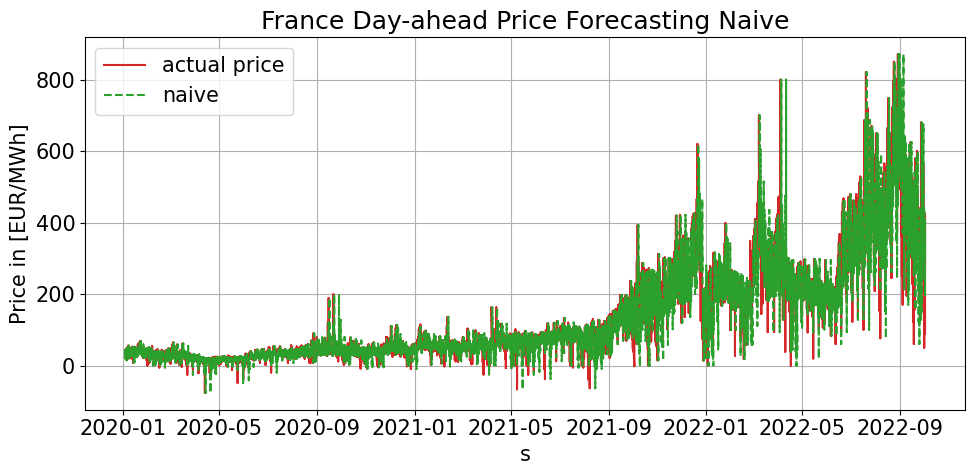

In [ ]:

df = pd.DataFrame({
    "actual": forecasts[:, :, 0].flatten(),
    "naive": forecasts[:, :, 1].flatten(),
    "expert": forecasts[:, :, 2].flatten(),
    "expert.readv": forecasts[:, :, 3].flatten(),
    "expert.last": forecasts[:, :, 4].flatten(),
    "lasso": forecasts[:, :, 5].flatten(),
    "ridge": forecasts[:, :, 6].flatten(),
    "elastic": forecasts[:, :, 7].flatten()
}, index=np.repeat(oos_dates, 24))

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 5))


actual_series = df["actual"]
naive_series = df["naive"]


# Plot the series
plt.plot(actual_series, linestyle='-', color='tab:red')
plt.plot(naive_series, linestyle='--', color='tab:green')


plt.ylabel("Price in [EUR/MWh]")
plt.xlabel("s")
plt.title("France Day-ahead Price Forecasting Naive")
plt.tight_layout()
plt.grid()
plt.legend(['actual price', 'naive'])
plt.show()

### Plot for expert

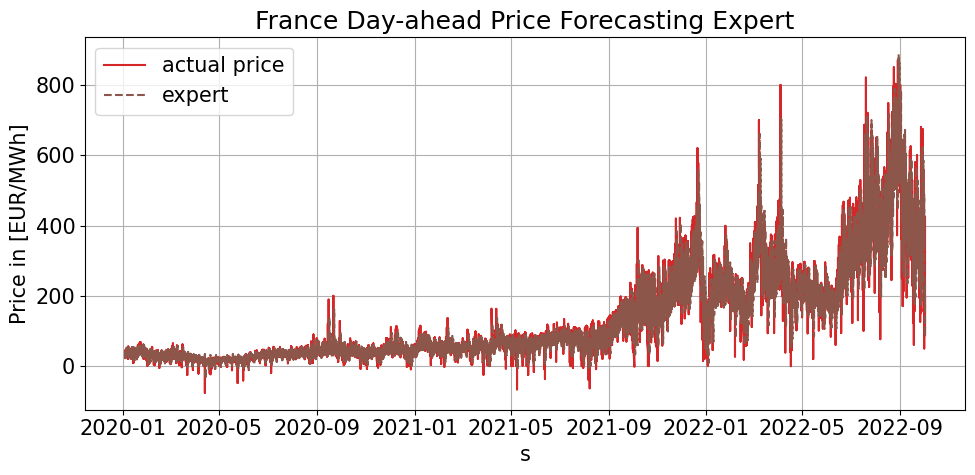

In [ ]:

actual_series = df["actual"]
expert_series = df["expert"]

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 5))
# Plot the series
plt.plot(actual_series, linestyle='-', color='tab:red')
plt.plot(expert_series, linestyle='--', color='tab:brown')

plt.ylabel("Price in [EUR/MWh]")
plt.xlabel("s")
plt.title("France Day-ahead Price Forecasting Expert")
plt.tight_layout()
plt.grid()
plt.legend(['actual price', 'expert'])

plt.show()

### Plot expert.readv

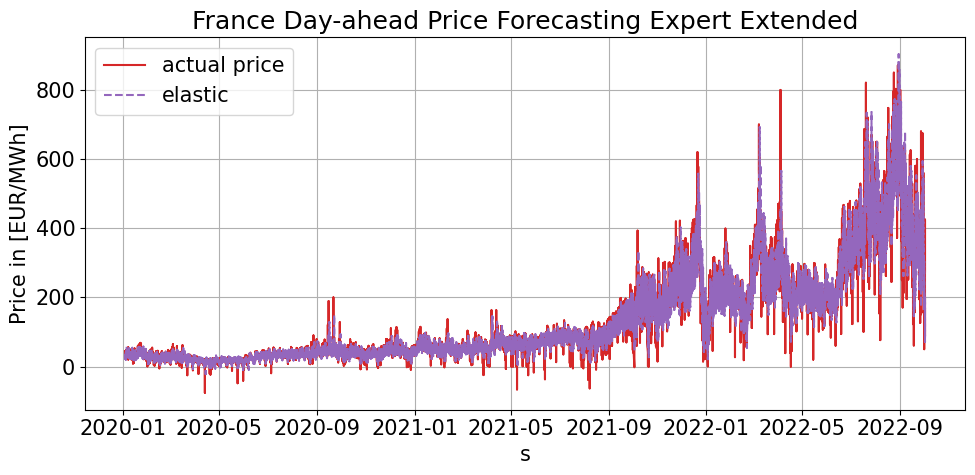

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 5))

# Extract the desired series
actual_series = df["actual"]
expert_readv = df["expert.readv"]

# Plot the series
plt.plot(actual_series, linestyle='-', color='tab:red')
plt.plot(expert_readv, linestyle='--', color='tab:purple')

plt.ylabel("Price in [EUR/MWh]")
plt.xlabel("s")
plt.title("France Day-ahead Price Forecasting Expert Extended")
plt.tight_layout()
plt.grid()
plt.legend(['actual price', 'elastic'])
#plt.savefig("out/illustration_forecast.pdf")
plt.show()

#### last

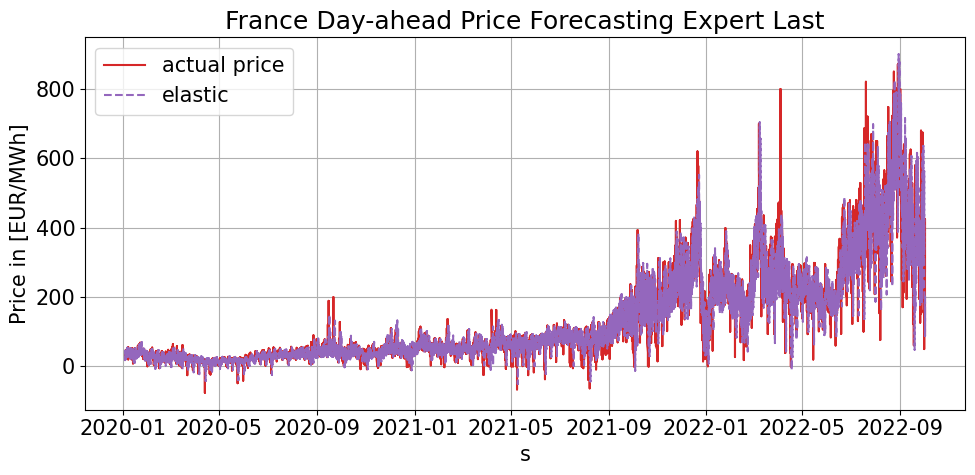

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 5))

# Extract the desired series
actual_series = df["actual"]
expert_last = df["expert.last"]

# Plot the series
plt.plot(actual_series, linestyle='-', color='tab:red')
plt.plot(expert_last, linestyle='--', color='tab:purple')

plt.ylabel("Price in [EUR/MWh]")
plt.xlabel("s")
plt.title("France Day-ahead Price Forecasting Expert Last")
plt.tight_layout()
plt.grid()
plt.legend(['actual price', 'elastic'])
#plt.savefig("out/illustration_forecast.pdf")
plt.show()

### Plot for Lasso

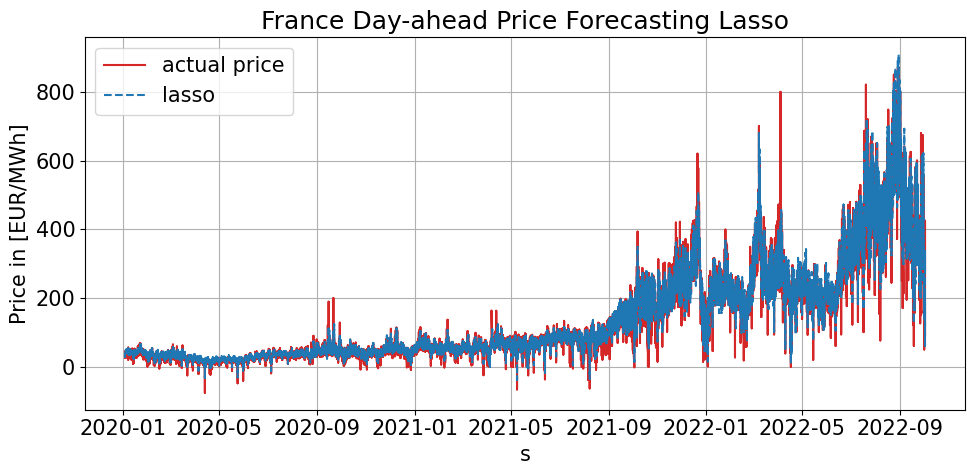

In [ ]:

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 5))

# Extract the desired series
actual_series = df["actual"]
lasso_series = df["lasso"]


# Plot the series
plt.plot(actual_series, linestyle='-', color='tab:red')
plt.plot(lasso_series, linestyle='--', color='tab:blue')


plt.ylabel("Price in [EUR/MWh]")
plt.xlabel("s")
plt.title("France Day-ahead Price Forecasting Lasso")
plt.tight_layout()
plt.grid()
plt.legend(['actual price', 'lasso'])
#plt.savefig("out/illustration_forecast.pdf")
plt.show()

#### Plot for ridge

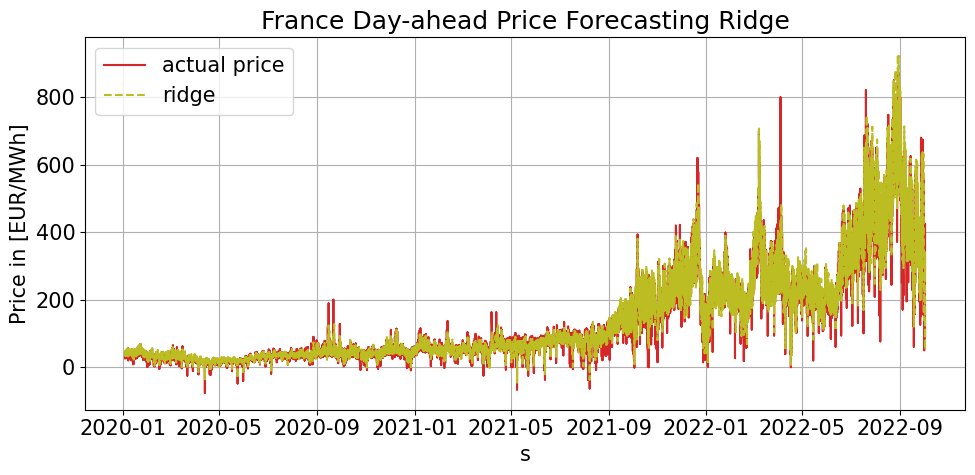

In [ ]:

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 5))

# # Extract the desired series
# actual_series = df["actual"]
ridge_series = df["ridge"]


# Plot the series
plt.plot(actual_series, linestyle='-', color='tab:red')
plt.plot(ridge_series, linestyle='--', color='tab:olive')


plt.ylabel("Price in [EUR/MWh]")
plt.xlabel("s")
plt.title("France Day-ahead Price Forecasting Ridge")
plt.tight_layout()
plt.grid()
plt.legend(['actual price', 'ridge'])
#plt.savefig("out/illustration_forecast.pdf")
plt.show()

#### Plot for elastic

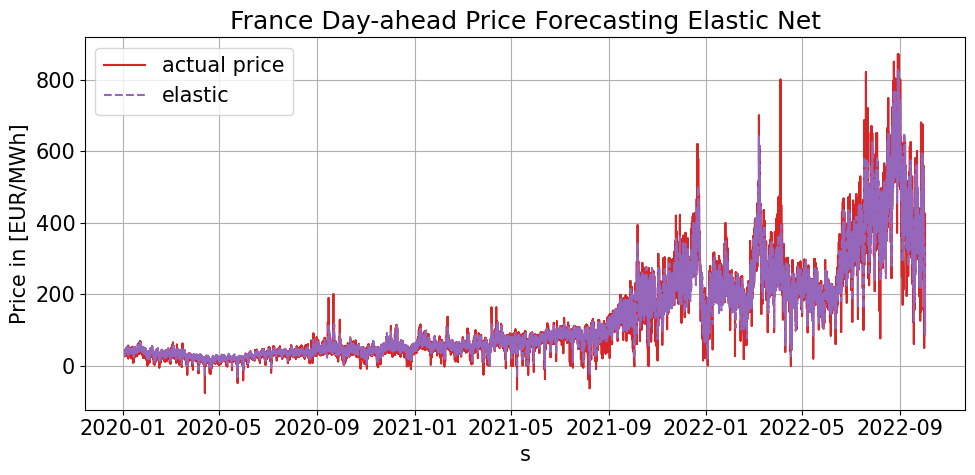

In [ ]:

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 5))

# Extract the desired series
actual_series = df["actual"]
elastic_series = df["elastic"]

# Plot the series
plt.plot(actual_series, linestyle='-', color='tab:red')
plt.plot(elastic_series, linestyle='--', color='tab:purple')

plt.ylabel("Price in [EUR/MWh]")
plt.xlabel("s")
plt.title("France Day-ahead Price Forecasting Elastic Net")
plt.tight_layout()
plt.grid()
plt.legend(['actual price', 'elastic'])
plt.show()

In [ ]:
errors = forecasts - forecasts[:, :, 0:1]
MAE_hourly = np.nanmean(np.abs(errors), axis=0)
RMSE_hourly = np.sqrt(np.nanmean(errors**2, axis=0))

In [ ]:
errors

array([[[ 0.00000000e+00, -4.64000000e+00,  2.47813276e-01, ...,
          4.32224156e+00,  2.64455485e-01,  2.84807022e+00],
        [ 0.00000000e+00, -2.55000000e+00,  2.99206876e-01, ...,
          5.05441168e+00,  3.05015598e+00,  4.82458000e+00],
        [ 0.00000000e+00, -4.39000000e+00, -1.61785125e-01, ...,
          6.75255380e+00,  5.90873259e+00,  6.64920419e+00],
        ...,
        [ 0.00000000e+00,  9.30000000e-01, -4.78985274e+00, ...,
          7.35510904e+00,  7.04306113e+00,  5.58418193e+00],
        [ 0.00000000e+00, -5.00000000e+00, -5.02811859e+00, ...,
          5.62373296e-01, -5.05303087e-01,  3.71303960e-01],
        [ 0.00000000e+00, -7.78000000e+00, -3.96902096e+00, ...,
          2.93127468e+00,  1.36757915e+00,  2.49578721e+00]],

       [[ 0.00000000e+00, -2.50000000e+00, -1.02349698e+00, ...,
          7.52050749e+00,  3.79713715e+00,  5.59743778e+00],
        [ 0.00000000e+00, -4.18000000e+00, -2.93918052e+00, ...,
          8.78593709e+00,  6.73018524e

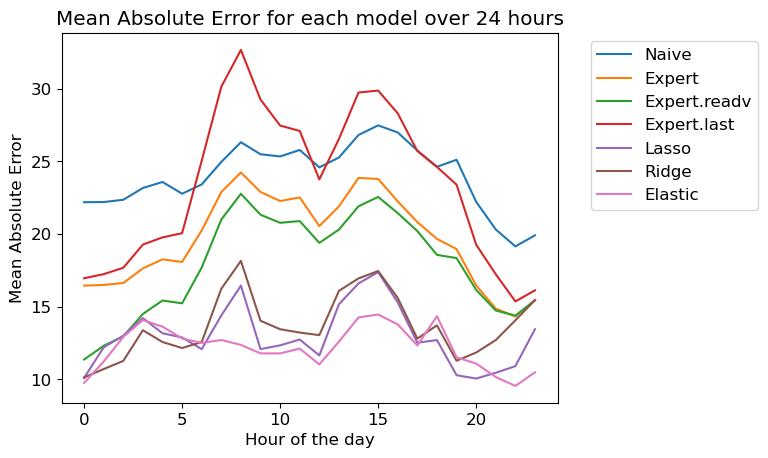

In [ ]:
model_names = ["Naive", "Expert", "Expert.readv", "Expert.last", "Lasso", "Ridge", "Elastic"]

# Plot the MAE for each model from columns 1 to 4
for model_idx in range(1, MAE_hourly.shape[1]):
    plt.plot(MAE_hourly[:, model_idx], label=f'{model_names[model_idx - 1]}')

plt.title("Mean Absolute Error for each model over 24 hours")
plt.xlabel("Hour of the day")
plt.ylabel("Mean Absolute Error")

# Move the legend outside the plot frame
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()




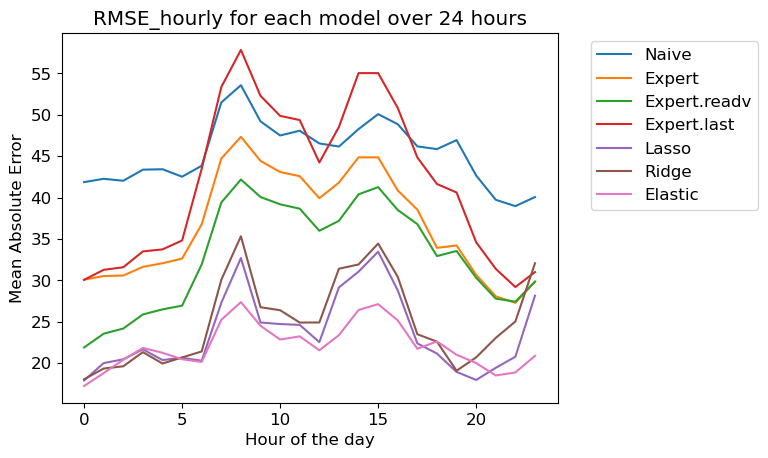

In [ ]:
model_names = ["Naive", "Expert", "Expert.readv", "Expert.last", "Lasso", "Ridge", "Elastic"]

# Plot the MAE for each model from columns 1 to 4
for model_idx in range(1, RMSE_hourly.shape[1]):
    plt.plot(RMSE_hourly[:, model_idx], label=f'{model_names[model_idx - 1]}')

plt.title("RMSE_hourly for each model over 24 hours")
plt.xlabel("Hour of the day")
plt.ylabel("Mean Absolute Error")

# Move the legend outside the plot frame
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
# Calculate the overall mean MAE for each model
overall_mean_MAE_models = np.mean(MAE_hourly, axis=0)
overall_mean_RMSE_models = np.mean(RMSE_hourly, axis=0)

In [ ]:
overall_mean_MAE_models

array([ 0.        , 23.99062022, 19.64808681, 17.90637785, 23.43967099,
       13.01110037, 13.70871058, 12.22642551])

In [ ]:
overall_mean_RMSE_models

array([ 0.        , 45.3902726 , 36.72239475, 33.02035872, 42.00268534,
       23.73847418, 25.13524172, 22.12531574])

["true", "naive", "expert", "expert.readv", "expert.last", "lasso", "ridge", "elastic"]

# Out-of-sample forecast

In [ ]:
# naive
for n in range(N_test):
    Y = price_S.iloc[n:D+n]
    days = pd.to_datetime(dates_S[n:D+n], utc=True)

    fc_naive_test = forecast_naive(Y=Y, days=days) #naive
    forecasts_test[n, :, 1] = fc_naive_test["forecasts"]



In [ ]:
# expert
for n in range(N_test):
    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])
    #Y = price_S.iloc[n:D + n]
    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    fc_expert_test = forecast_expert(Y=Y, days=days, expert_wd=expert_wd,
                                expert_lags=expert_lags)
    forecasts_test[n, :, 2] = fc_expert_test["forecasts"]




In [ ]:

# last
for n in range(N_test):
    # 'model' 1 is the true price to forecast (prediction target)
    #forecasts[n, :, 0] = price_S.iloc[D+n]
    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])
    #Y = price_S.iloc[n:D + n]
    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    fc_expert_last_test = forecast_expert_last(Y=Y, days=days, expert_wd=expert_wd,
                                expert_lags=expert_lags)
    forecasts_test[n, :, 3] = fc_expert_last_test["forecasts"]


In [ ]:
for n in range(N_test):
    # 'model' 1 is the true price to forecast (prediction target)
    #forecasts[n, :, 0] = price_S.iloc[D+n]
    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])
    #Y = price_S.iloc[n:D + n]
    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    fc_expert_readv_test= forecast_expert_ext(Y=Y, days=days, expert_wd=expert_wd, expert_lags=expert_lags, 
                              fuel_lags=fuel_lags, output_lags=output_lags, index=index)
    forecasts_test[n, :, 4] = fc_expert_readv_test["forecasts"]

-> 36.3908% done

In [ ]:
## lasso
for n in range(N_test):
    ## true price for comparing
    forecasts_test[n, :, 0] = price_S.iloc[D + n]

    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])
    #Y = price_S.iloc[n:D + n]
    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    # Lasso model
    fc_lasso_test = forecast_lasso(Y=Y, days=days, expert_wd=expert_wd, expert_lags=expert_lags, lambdas=lambdas, 
                              fuel_lags=fuel_lags, output_lags=output_lags, index=index) # , index_ext=index_ext
    forecasts_test[n, :, 5] = fc_lasso_test["forecasts"]

In [ ]:

# Access the dataframes
final_forecast_lasso_test = forecasts_test[-1, :, 5]
final_best_alpha_lasso_test = fc_lasso_test["best_alpha"][-1]
final_best_coefs_df_lasso_test = fc_lasso_test["best_coefs"][-1]

In [ ]:
# ridge

for n in range(N_test):

    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])
    #Y = price_S.iloc[n:D + n]
    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    # Ridge model
    fc_ridge_test = forecast_ridge(Y=Y, days=days, expert_wd=expert_wd, expert_lags=expert_lags, lambdas=lambdas, 
                              fuel_lags=fuel_lags, output_lags=output_lags, index=index) # , index_ext=index_ext
    forecasts_test[n, :, 6] = fc_ridge_test["forecasts"]

In [ ]:
# elastic
for n in range(N_test):

    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])
    #Y = price_S.iloc[n:D + n]
    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    # Elastic model
    fc_elastic_test = forecast_sg_lasso(Y=Y, days=days, expert_wd=expert_wd, expert_lags=expert_lags, lambdas=lambdas, 
                              fuel_lags=fuel_lags, output_lags=output_lags, index=index, alpha_ratio=0.5)
    forecasts_test[n, :, 7] = fc_elastic_test["forecasts"]


In [ ]:
errors_test = forecasts_test - forecasts_test[:, :, 0:1]
MAE_test = np.nanmean(np.abs(errors_test), axis=0)
RMSE_test = np.sqrt(np.nanmean(errors_test**2, axis=0))


In [ ]:
MAE_test

array([[ 0.        ,  5.87539726,  4.53740668,  2.64134142,  5.18552146,
         2.49162744,  2.49476325,  3.05793058],
       [ 0.        ,  5.73917808,  4.29874595,  2.88299897,  5.30027057,
         4.28097701,  3.10278815,  5.17271856],
       [ 0.        ,  6.0050137 ,  4.55969713,  3.24541134,  5.57520813,
         6.36642824,  4.77857672,  7.03871413],
       [ 0.        ,  6.67967123,  4.96789796,  3.90400308,  6.22471207,
         7.42451894,  7.44176237,  7.73955084],
       [ 0.        ,  6.75052055,  5.09065477,  4.24807639,  6.4222311 ,
         7.31341318,  6.78484293,  7.48353106],
       [ 0.        ,  6.45331507,  4.97352965,  3.95573423,  6.50926345,
         7.14148339,  5.48871154,  7.32267031],
       [ 0.        ,  6.33210959,  5.40108613,  4.59363691,  8.06849775,
         7.4030005 ,  5.53671206,  6.418754  ],
       [ 0.        ,  6.366     ,  5.85370022,  5.18887908,  9.85535011,
         3.795991  ,  3.70352289,  3.91677792],
       [ 0.        ,  6.85446575

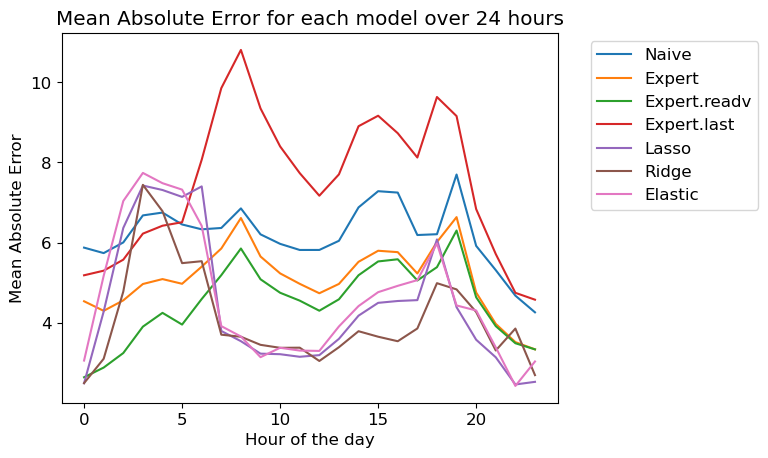

In [ ]:
model_names = ["Naive", "Expert", "Expert.readv", "Expert.last", "Lasso", "Ridge", "Elastic"]

# Plot the MAE for each model from columns 1 to 4
for model_idx in range(1, MAE_test.shape[1]):
    plt.plot(MAE_test[:, model_idx], label=f'{model_names[model_idx - 1]}')

plt.title("Mean Absolute Error for each model over 24 hours")
plt.xlabel("Hour of the day")
plt.ylabel("Mean Absolute Error")

# Move the legend outside the plot frame
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

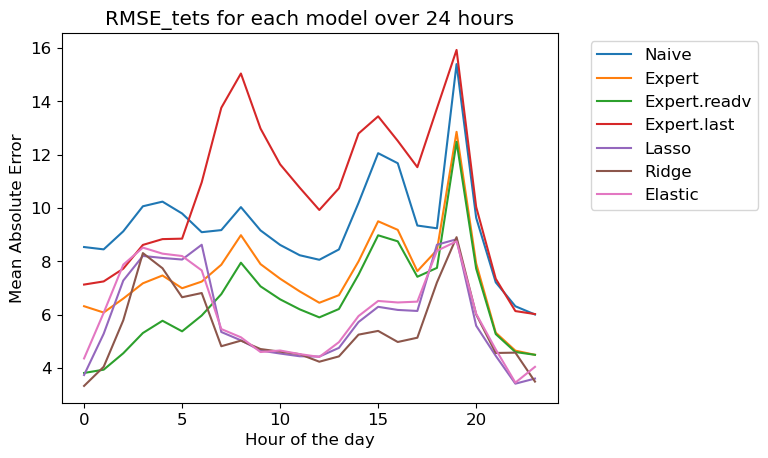

In [ ]:

model_names = ["Naive", "Expert", "Expert.readv", "Expert.last", "Lasso", "Ridge", "Elastic"]

# Plot the MAE for each model from columns 1 to 4
for model_idx in range(1, RMSE_test.shape[1]):
    plt.plot(RMSE_test[:, model_idx], label=f'{model_names[model_idx - 1]}')

plt.title("RMSE_tets for each model over 24 hours")
plt.xlabel("Hour of the day")
plt.ylabel("Mean Absolute Error")

# Move the legend outside the plot frame
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
# Calculate the overall mean MAE for each model
overall_mean_MAE_models_test = np.mean(MAE_test, axis=0)
overall_mean_RMSE_models_test = np.mean(RMSE_test, axis=0)

In [ ]:
overall_mean_RMSE_models_test

array([ 0.        ,  9.34240706,  7.42306229,  6.52188413, 10.57590506,
        5.89677362,  5.44583975,  6.06946546])

### DM test

In [ ]:
from scipy.stats import t

In [ ]:
def dm_test(error_a, error_b, hmax=1, power=1):
    # as dm_test with alternative == "less"
    loss_a = (np.abs(error_a)**power).sum(1)**(1/power)
    loss_b = (np.abs(error_b)**power).sum(1)**(1/power)
    delta = loss_a - loss_b
    # estimation of the variance
    delta_var = np.var(delta) / delta.shape[0]
    statistic = delta.mean() / np.sqrt(delta_var)
    delta_length = delta.shape[0]
    k = ((delta_length + 1 - 2 * hmax + (hmax / delta_length)
         * (hmax - 1)) / delta_length)**(1 / 2)
    statistic = statistic * k
    p_value = t.cdf(statistic, df=delta_length-1)

    return {"stat": statistic, "p_val": p_value}


# %% Now test the naive model vs. expert model
dm_test(errors[..., 1], errors[..., 2])


{'stat': 6.4623634886700945, 'p_val': 0.9999999999196822}

In [ ]:


errors_wo_true = errors[..., 1:]
model_names_wo_true = [str(i+1) + "_" + model_names[i+1]
                       for i in range(len(model_names)-1)]

dm_results_df = pd.DataFrame(
    columns=model_names_wo_true, index=model_names_wo_true, dtype=np.float64)

dm_results = {"p_val": dm_results_df.copy(), "t_stat": dm_results_df.copy()}
dm_results["p_val"].loc[:, "type"] = "p_val"
dm_results["t_stat"].loc[:, "type"] = "t_stat"

# Calculate p-values and t-statistics
for model1 in model_names_wo_true:
    for model2 in model_names_wo_true:
        if model1 != model2:
            errors1 = errors_wo_true[:, model_names_wo_true.index(model1)]
            errors2 = errors_wo_true[:, model_names_wo_true.index(model2)]
            
            # Find common non-NaN indices
            valid_indices = ~np.isnan(errors1) & ~np.isnan(errors2)
            
            if np.any(valid_indices):  # Check if there are common non-NaN values
                errors1_valid = errors1[valid_indices]
                errors2_valid = errors2[valid_indices]
                
                # Calculate t-statistics and p-values
                t_stat, p_val = ttest_rel(errors1_valid, errors2_valid, axis=0)
                
                # Store the mean values in the result DataFrame
                dm_results["t_stat"].loc[model1, model2] = np.mean(t_stat)
                dm_results["p_val"].loc[model1, model2] = np.mean(p_val)



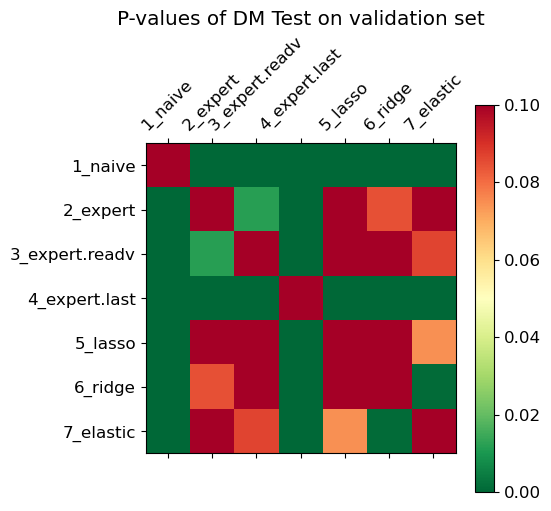

In [ ]:
dm_results["p_val"] = dm_results["p_val"].fillna(1)

plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(5, 5))
plt.matshow(dm_results["p_val"].iloc[:, :-1],
            fignum=fig.number, cmap=plt.cm.RdYlGn.reversed(), vmin=0, vmax=0.1)
plt.xticks(ticks=np.arange(
    errors_wo_true.shape[-1]), labels=model_names_wo_true, rotation=45)
plt.yticks(ticks=np.arange(
    errors_wo_true.shape[-1]), labels=model_names_wo_true)
cb = plt.colorbar()
plt.title("P-values of DM Test on validation set")
plt.show()

In [ ]:

errors_wo_true = errors_test[..., 1:]
model_names_wo_true = [str(i+1) + "_" + model_names[i+1]
                       for i in range(len(model_names)-1)]

dm_results_df = pd.DataFrame(
    columns=model_names_wo_true, index=model_names_wo_true, dtype=np.float64)

dm_results = {"p_val": dm_results_df.copy(), "t_stat": dm_results_df.copy()}
dm_results["p_val"].loc[:, "type"] = "p_val"
dm_results["t_stat"].loc[:, "type"] = "t_stat"

# Calculate p-values and t-statistics
for model1 in model_names_wo_true:
    for model2 in model_names_wo_true:
        if model1 != model2:
            errors1 = errors_wo_true[:, model_names_wo_true.index(model1)]
            errors2 = errors_wo_true[:, model_names_wo_true.index(model2)]
            
            # Find common non-NaN indices
            valid_indices = ~np.isnan(errors1) & ~np.isnan(errors2)
            
            if np.any(valid_indices):  # Check if there are common non-NaN values
                errors1_valid = errors1[valid_indices]
                errors2_valid = errors2[valid_indices]
                
                # Calculate t-statistics and p-values
                t_stat, p_val = ttest_rel(errors1_valid, errors2_valid, axis=0)
                
                # Store the mean values in the result DataFrame
                dm_results["t_stat"].loc[model1, model2] = np.mean(t_stat)
                dm_results["p_val"].loc[model1, model2] = np.mean(p_val)
# P-values


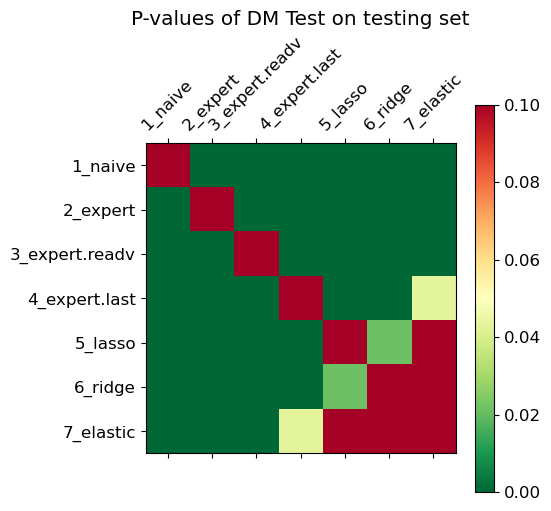

In [ ]:
dm_results["p_val"] = dm_results["p_val"].fillna(1)
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(5, 5))
plt.matshow(dm_results["p_val"].iloc[:, :-1],
            fignum=fig.number, cmap=plt.cm.RdYlGn.reversed(), vmin=0, vmax=0.1)
plt.xticks(ticks=np.arange(
    errors_wo_true.shape[-1]), labels=model_names_wo_true, rotation=45)
plt.yticks(ticks=np.arange(
    errors_wo_true.shape[-1]), labels=model_names_wo_true)
cb = plt.colorbar()
plt.title("P-values of DM Test on testing set")
plt.show()